<a href="https://colab.research.google.com/github/REU2024/CyberFusion/blob/main/notebooks/CyberFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load the three tables (CSV or XLSX)**

In [ ]:
import pandas as pd
import os

def read_table(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        df = pd.read_csv(path)
    elif ext in (".xlsx", ".xls"):
        # read first sheet
        xls = pd.ExcelFile(path)
        df = pd.read_excel(path, sheet_name=xls.sheet_names[0])
    else:
        raise ValueError(f"Unsupported file type: {ext}")
    # normalize columns: lower + strip spaces
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df

ben_path  = "/content/benign.xlsx"      if os.path.exists("/content/benign.xlsx")      else "/content/benign.csv"
mal_path  = "/content/malware.xlsx"     if os.path.exists("/content/malware.xlsx")     else "/content/malware.csv"
ran_path  = "/content/ransomware.xlsx"  if os.path.exists("/content/ransomware.xlsx")  else "/content/ransomware.csv"

ben = read_table(ben_path)
mal = read_table(mal_path)
ran = read_table(ran_path)

print("benign cols:", list(ben.columns)[:15])
print("malware cols:", list(mal.columns)[:15])
print("ransom cols:", list(ran.columns)[:15])


benign cols: ['characteristics', 'compile_time', 'dll_characteristics', 'entry_point', 'error', 'exports', 'file_size', 'filename', 'filepath', 'image_base', 'imports', 'is_pe', 'linker_version', 'machine_type', 'md5']
malware cols: ['filename', 'instructions', 'api_calls', 'json']
ransom cols: ['filename', 'instructions', 'api_calls', 'json']


## **3) Standardize columns and add labels**

In [ ]:
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def to_dataset(df, label_name):
    # map to static_seq / dynamic_seq
    instr_col = pick_first_existing(df, ["instructions", "opcodes", "opcode_seq", "instr"])
    api_col   = pick_first_existing(df, ["api_calls", "apis", "api_seq"])
    fname_col = pick_first_existing(df, ["filename", "file_name", "name"])
    # fill missing safely
    out = pd.DataFrame({
        "filename": df[fname_col] if fname_col else [None]*len(df),
        "static_seq": df[instr_col].astype(str) if instr_col else ["" for _ in range(len(df))],
        "dynamic_seq": df[api_col].astype(str) if api_col else ["" for _ in range(len(df))],
        "label": label_name
    })
    # has_dynamic flag
    out["has_dynamic"] = (out["dynamic_seq"].str.len() > 0).astype(int)
    return out

ben_ds = to_dataset(ben, "benign")
mal_ds = to_dataset(mal, "malware")
ran_ds = to_dataset(ran, "ransomware")

full = pd.concat([ben_ds, mal_ds, ran_ds], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)
full.head()
full["label"].value_counts()
full["has_dynamic"].value_counts()


,count
has_dynamic,
1,13484
0,1930


## **Step 1 (next): Split into train / val / test (stratified by label)**

In [ ]:
from sklearn.model_selection import train_test_split

# 70/15/15 split
train_df, temp_df = train_test_split(
    full, test_size=0.30, random_state=1337, stratify=full["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=1337, stratify=temp_df["label"]
)

print("Train:", train_df["label"].value_counts())
print("Val  :", val_df["label"].value_counts())
print("Test :", test_df["label"].value_counts())


Train: label
malware       6112
ransomware    3326
benign        1351
Name: count, dtype: int64
Val  : label
malware       1310
ransomware     713
benign         289
Name: count, dtype: int64
Test : label
malware       1310
ransomware     713
benign         290
Name: count, dtype: int64


## **Step 2 (next): Vectorize static and dynamic sequences**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizers (can adjust ngram_range/max_features later)
tfidf_static  = TfidfVectorizer(token_pattern=r"[^,\s]+", ngram_range=(1,2), min_df=3, max_features=100_000)
tfidf_dynamic = TfidfVectorizer(token_pattern=r"[^,\s]+", ngram_range=(1,2), min_df=3, max_features=100_000)

# Fit on training data only
X_static_tr  = tfidf_static.fit_transform(train_df["static_seq"])
X_dynamic_tr = tfidf_dynamic.fit_transform(train_df["dynamic_seq"])

print("Static shape:", X_static_tr.shape)
print("Dynamic shape:", X_dynamic_tr.shape)


Static shape: (10789, 7645)
Dynamic shape: (10789, 4712)


## **Step 3 (next): Transform val/test and fuse static + dynamic**

In [ ]:
from scipy.sparse import hstack

# Transform val/test with the TF-IDF models fitted on train
X_static_val  = tfidf_static.transform(val_df["static_seq"])
X_dynamic_val = tfidf_dynamic.transform(val_df["dynamic_seq"])

X_static_te   = tfidf_static.transform(test_df["static_seq"])
X_dynamic_te  = tfidf_dynamic.transform(test_df["dynamic_seq"])

# Fuse (concatenate) static and dynamic features
X_tr  = hstack([X_static_tr,  X_dynamic_tr],  format="csr")
X_val = hstack([X_static_val, X_dynamic_val], format="csr")
X_te  = hstack([X_static_te,  X_dynamic_te],  format="csr")

X_tr.shape, X_val.shape, X_te.shape


((10789, 12357), (2312, 12357), (2313, 12357))

## **Step 4 (next): Train the classifier and check validation performance**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Encode labels
label_map = {"benign": 0, "malware": 1, "ransomware": 2}
y_tr  = train_df["label"].map(label_map).values
y_val = val_df["label"].map(label_map).values

# Train a strong baseline
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_tr, y_tr)

# Validate
val_pred = clf.predict(X_val)
print(classification_report(y_val, val_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

      benign       0.99      1.00      0.99       289
     malware       0.89      1.00      0.94      1310
  ransomware       0.99      0.76      0.86       713

    accuracy                           0.92      2312
   macro avg       0.96      0.92      0.93      2312
weighted avg       0.93      0.92      0.92      2312



## **Step 5 (next): Evaluate on the held-out test set**

              precision    recall  f1-score   support

      benign       0.97      1.00      0.99       290
     malware       0.89      0.99      0.94      1310
  ransomware       1.00      0.76      0.87       713

    accuracy                           0.92      2313
   macro avg       0.95      0.92      0.93      2313
weighted avg       0.93      0.92      0.92      2313



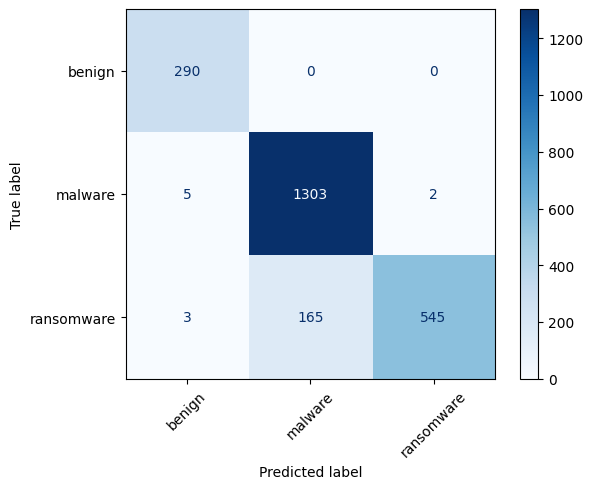

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Encode test labels
y_te = test_df["label"].map(label_map).values

# Predict on test set
test_pred = clf.predict(X_te)

# Print classification report
print(classification_report(y_te, test_pred, target_names=label_map.keys()))

# Show confusion matrix
cm = confusion_matrix(y_te, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="Blues", xticks_rotation=45)


## **Step 6 (next): Save your model & vectorizers**

In [ ]:
import joblib

# Save model
joblib.dump(clf, "malware_ransomware_model.pkl")

# Save vectorizers
joblib.dump(tfidf_static, "tfidf_static.pkl")
joblib.dump(tfidf_dynamic, "tfidf_dynamic.pkl")


['tfidf_dynamic.pkl']

In [ ]:
clf = joblib.load("malware_ransomware_model.pkl")
tfidf_static = joblib.load("tfidf_static.pkl")
tfidf_dynamic = joblib.load("tfidf_dynamic.pkl")


## **Step 7 (next): Try a stronger model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_tr, y_tr)

# Validate
rf_val_pred = rf_clf.predict(X_val)
print(classification_report(y_val, rf_val_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       289
     malware       1.00      0.79      0.88      1310
  ransomware       0.72      1.00      0.84       713

    accuracy                           0.88      2312
   macro avg       0.91      0.93      0.91      2312
weighted avg       0.91      0.88      0.88      2312



## **Step DL-1 (next): Tokenize sequences for a neural net**

In [ ]:
# STEP DL-1: build tokenizers and convert to integer sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----- hyperparams you can tweak later -----
MAX_STATIC_TOKENS  = 4000   # vocab size for opcodes/instructions
MAX_DYNAMIC_TOKENS = 4000   # vocab size for API names
MAXLEN_STATIC      = 2000   # max opcode tokens per sample
MAXLEN_DYNAMIC     = 800    # max API tokens per sample
# ------------------------------------------

# use whitespace/comma split; we already TF-IDF'd with token_pattern r"[^,\s]+"
def corpus(col):
    return col.astype(str).tolist()

# add a placeholder for "no dynamic"
NO_API_TOKEN = "<NO_API>"
train_dyn = train_df["dynamic_seq"].replace({"": NO_API_TOKEN})
val_dyn   = val_df["dynamic_seq"].replace({"": NO_API_TOKEN})
test_dyn  = test_df["dynamic_seq"].replace({"": NO_API_TOKEN})

# --- static tokenizer (opcodes) ---
tok_static = Tokenizer(num_words=MAX_STATIC_TOKENS, filters="", lower=False, split=" ")
tok_static.fit_on_texts(corpus(train_df["static_seq"]))

Xst_tr = tok_static.texts_to_sequences(train_df["static_seq"])
Xst_val= tok_static.texts_to_sequences(val_df["static_seq"])
Xst_te = tok_static.texts_to_sequences(test_df["static_seq"])

Xst_tr = pad_sequences(Xst_tr, maxlen=MAXLEN_STATIC, truncating="post")
Xst_val= pad_sequences(Xst_val, maxlen=MAXLEN_STATIC, truncating="post")
Xst_te = pad_sequences(Xst_te, maxlen=MAXLEN_STATIC, truncating="post")

# --- dynamic tokenizer (APIs) ---
tok_dyn = Tokenizer(num_words=MAX_DYNAMIC_TOKENS, filters="", lower=False, split=" ")
tok_dyn.fit_on_texts(corpus(train_dyn))

Xdy_tr = tok_dyn.texts_to_sequences(train_dyn)
Xdy_val= tok_dyn.texts_to_sequences(val_dyn)
Xdy_te = tok_dyn.texts_to_sequences(test_dyn)

Xdy_tr = pad_sequences(Xdy_tr, maxlen=MAXLEN_DYNAMIC, truncating="post")
Xdy_val= pad_sequences(Xdy_val, maxlen=MAXLEN_DYNAMIC, truncating="post")
Xdy_te = pad_sequences(Xdy_te, maxlen=MAXLEN_DYNAMIC, truncating="post")

print("Static seq shapes:", Xst_tr.shape, Xst_val.shape, Xst_te.shape)
print("Dynamic seq shapes:", Xdy_tr.shape, Xdy_val.shape, Xdy_te.shape)

# y labels for Keras (same mapping)
import numpy as np
label_map = {"benign":0,"malware":1,"ransomware":2}
y_tr  = train_df["label"].map(label_map).values
y_val = val_df["label"].map(label_map).values
y_te  = test_df["label"].map(label_map).values


Static seq shapes: (10789, 2000) (2312, 2000) (2313, 2000)
Dynamic seq shapes: (10789, 800) (2312, 800) (2313, 800)


## **Step DL-2 (next): Build the hybrid neural network (encoders + gated fusion + modality-dropout)**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# --- gated fusion (safe Keras version) ---
gate_in = layers.Concatenate()([st, dy, hasdyn_in])
g = layers.Dense(64, activation="relu")(gate_in)
g = layers.Dense(1, activation="sigmoid", name="gate")(g)   # in [0,1]

# ones_like as a Keras layer (avoids KerasTensor -> TF op error)
one = layers.Lambda(lambda x: tf.ones_like(x), name="ones_like")(g)
one_minus_g = layers.Subtract(name="one_minus_g")([one, g])

h_dyn = layers.Multiply(name="scale_dyn")([g, dy])
h_st  = layers.Multiply(name="scale_static")([one_minus_g, st])
h = layers.Add(name="fused")([h_dyn, h_st])

# classifier head (redefine these layers after fusion)
h = layers.Dense(128, activation="relu")(h)
h = layers.Dropout(0.3)(h)
out = layers.Dense(3, activation="softmax", name="pred")(h)

model = tf.keras.Model(inputs=[static_in, dynamic_in, hasdyn_in], outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dynamic_in          │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dynamic         │ (None, 800, 64)   │     19,136 │ dynamic_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 800)       │          0 │ dynamic_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 800, 128)  │     66,048 │ emb_dynamic[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_static          │ (None, 2000, 64)  │    256,000 │ static_in[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2000, 128) │     41,088 │ emb_static[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hasdyn_in           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ dropout[0][0],    │
│                     │                   │            │ hasdyn_in[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 257)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ multiply[0][0],   │
│                     │                   │            │ hasdyn_in[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     16,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate (Dense)        │ (None, 1)         │         65 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like (Lambda)  │ (None, 1)         │          0 │ gate[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_minus_g         │ (None, 1)         │          0 │ ones_like[0][0],

 Total params: 448,772 (1.71 MB)

 Trainable params: 448,772 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

## **Step DL-2 (next): Train with early stopping & class weights**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Class weights (inverse of frequency)
classes, counts = np.unique(y_tr, return_counts=True)
total = sum(counts)
class_weights = {cls: total/(len(classes)*count) for cls, count in zip(classes, counts)}
print("Class weights:", class_weights)

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train
history = model.fit(
    [Xst_tr, Xdy_tr, train_df["has_dynamic"].values],
    y_tr,
    validation_data=([Xst_val, Xdy_val, val_df["has_dynamic"].values], y_val),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Class weights: {np.int64(0): np.float64(2.6619787811497657), np.int64(1): np.float64(0.5884053228621291), np.int64(2): np.float64(1.0812788133894569)}
Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.7410 - loss: 0.5890 - val_accuracy: 0.8763 - val_loss: 0.2398
Epoch 2/15
 40/169 ━━━━━━━━━━━━━━━━━━━━ 6:27 3s/step - accuracy: 0.8975 - loss: 0.1351

## **Switching Runtime to T4 GPU**

In [ ]:
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices("GPU"))


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models


In [ ]:
import pandas as pd

# correct CSV paths (as shown in your left panel)
ben = pd.read_csv("/content/benign.csv")
mal = pd.read_csv("/content/malware.csv")
ran = pd.read_csv("/content/ransomware.csv")

# sanity check
print("benign shape:", ben.shape)
print("malware shape:", mal.shape)
print("ransom shape:", ran.shape)
print("\nFirst benign columns:", list(ben.columns)[:15])
print("First malware columns:", list(mal.columns)[:15])
print("First ransomware columns:", list(ran.columns)[:15])


benign shape: (1930, 28)
malware shape: (8732, 4)
ransom shape: (4752, 4)

First benign columns: ['characteristics', 'compile_time', 'dll_characteristics', 'entry_point', 'error', 'exports', 'file_size', 'filename', 'filepath', 'image_base', 'imports', 'is_pe', 'linker_version', 'machine_type', 'md5']
First malware columns: ['filename', 'instructions', 'api_calls', 'json']
First ransomware columns: ['filename', 'instructions', 'api_calls', 'json']


## **Standardize + Add Labels**

In [ ]:
def to_dataset(df, label_name):
    instr_col = next((c for c in df.columns if c.lower() in ["instructions","opcodes","opcode_seq"]), None)
    api_col   = next((c for c in df.columns if c.lower() in ["api_calls","apis","api_seq"]), None)
    fname_col = next((c for c in df.columns if "file" in c.lower() or "name" in c.lower()), None)

    out = pd.DataFrame({
        "filename": df[fname_col] if fname_col else [None]*len(df),
        "static_seq": df[instr_col].astype(str) if instr_col else ["" for _ in range(len(df))],
        "dynamic_seq": df[api_col].astype(str) if api_col else ["" for _ in range(len(df))],
        "label": label_name
    })
    out["has_dynamic"] = (out["dynamic_seq"].str.len() > 0).astype(int)
    return out

ben_ds = to_dataset(ben, "benign")
mal_ds = to_dataset(mal, "malware")
ran_ds = to_dataset(ran, "ransomware")

# merge and shuffle
full = pd.concat([ben_ds, mal_ds, ran_ds], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

print(full["label"].value_counts())
print(full["has_dynamic"].value_counts())
full.head()


label
malware       8732
ransomware    4752
benign        1930
Name: count, dtype: int64
has_dynamic
1    13484
0     1930
Name: count, dtype: int64


,filename,static_seq,dynamic_seq,label,has_dynamic
0,c1bb6da6934f87f45429ba0c4804c56a33023f50b37bcc...,mov:0x401000;push:0x401002;mov:0x401003;sub:0x...,nan,malware,1
1,0f89afcaa627b82a4235fe79aaf2f3123fc9bd6435b9d5...,jmp:0x401000;outsd:0x401002;and:0x401004;imul:...,nan,ransomware,1
2,93389b4c64aa3a688c712f36f3c80aa898597af3aa99fe...,inc:0x401000;salc:0x401001;nop:0x42e000;pushal...,NtOpenMutant; GetSystemDirectoryA; CopyFileA; ...,ransomware,1
3,66e0cd9a43757292cc06bdc373665ea8e632c130bc77b4...,mov:0x401000;add:0x401002;retf:0x401004;add:0x...,nan,malware,1
4,17920,,,benign,0


## **Clean text columns and make the stratified split**

In [ ]:
from sklearn.model_selection import train_test_split

# 1) Clean NaNs → empty strings, ensure string dtype
for col in ["static_seq", "dynamic_seq", "filename"]:
    full[col] = full[col].fillna("").astype(str)

# (re)compute has_dynamic after cleaning
full["has_dynamic"] = (full["dynamic_seq"].str.len() > 0).astype(int)

# 2) Stratified 70/15/15 split by label
train_df, temp_df = train_test_split(
    full, test_size=0.30, random_state=1337, stratify=full["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=1337, stratify=temp_df["label"]
)

print("Train:", train_df["label"].value_counts().to_dict())
print("Val  :", val_df["label"].value_counts().to_dict())
print("Test :", test_df["label"].value_counts().to_dict())


Train: {'malware': 6112, 'ransomware': 3326, 'benign': 1351}
Val  : {'malware': 1310, 'ransomware': 713, 'benign': 289}
Test : {'malware': 1310, 'ransomware': 713, 'benign': 290}


## **turn text → numbers (TF-IDF) for both columns**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Treat tokens as comma/space separated; use unigrams + bigrams
tfidf_static  = TfidfVectorizer(token_pattern=r"[^,\s]+", ngram_range=(1,2),
                                min_df=3, max_features=100_000)
tfidf_dynamic = TfidfVectorizer(token_pattern=r"[^,\s]+", ngram_range=(1,2),
                                min_df=3, max_features=100_000)

# Fit on TRAIN only
Xst_tr  = tfidf_static.fit_transform(train_df["static_seq"])
Xdy_tr  = tfidf_dynamic.fit_transform(train_df["dynamic_seq"])

# Transform VAL/TEST with the same vectorizers
Xst_val = tfidf_static.transform(val_df["static_seq"])
Xdy_val = tfidf_dynamic.transform(val_df["dynamic_seq"])
Xst_te  = tfidf_static.transform(test_df["static_seq"])
Xdy_te  = tfidf_dynamic.transform(test_df["dynamic_seq"])

# Fuse static + dynamic (rows with empty dynamic just contribute zeros)
X_tr  = hstack([Xst_tr,  Xdy_tr],  format="csr")
X_val = hstack([Xst_val, Xdy_val], format="csr")
X_te  = hstack([Xst_te,  Xdy_te],  format="csr")

print("Train shape:", X_tr.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_te.shape)

# Numeric labels for later
label_map = {"benign":0, "malware":1, "ransomware":2}
y_tr  = train_df["label"].map(label_map).values
y_val = val_df["label"].map(label_map).values
y_te  = test_df["label"].map(label_map).values


Train shape: (10789, 12357)
Val   shape: (2312, 12357)
Test  shape: (2313, 12357)


## **train a baseline model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression (baseline)
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_tr, y_tr)

# Validate
val_pred = clf.predict(X_val)
print(classification_report(y_val, val_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

      benign       0.99      1.00      0.99       289
     malware       0.89      1.00      0.94      1310
  ransomware       0.99      0.76      0.86       713

    accuracy                           0.92      2312
   macro avg       0.96      0.92      0.93      2312
weighted avg       0.93      0.92      0.92      2312



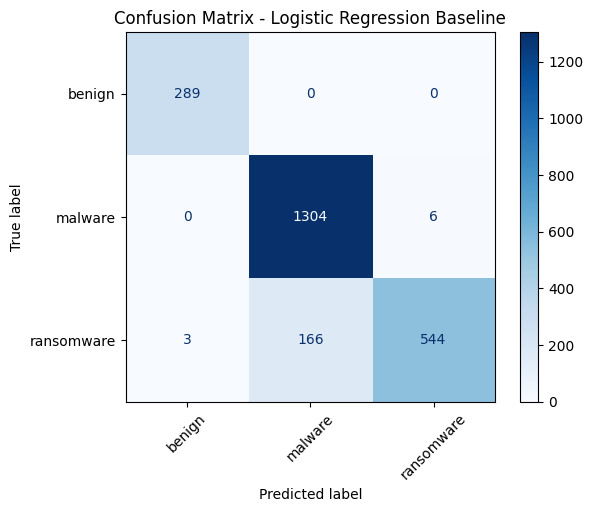

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_val, val_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()


## **Deep Learning Models**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Inputs
static_in = layers.Input(shape=(2000,), name="static_in")   # static opcode sequence
dynamic_in = layers.Input(shape=(800,), name="dynamic_in")  # dynamic API call sequence

# Static branch (CNN)
emb_static = layers.Embedding(input_dim=10000, output_dim=64, mask_zero=True)(static_in)
conv1 = layers.Conv1D(128, kernel_size=5, activation="relu")(emb_static)
pool1 = layers.GlobalMaxPooling1D()(conv1)

# Dynamic branch (BiLSTM)
emb_dynamic = layers.Embedding(input_dim=5000, output_dim=64, mask_zero=True)(dynamic_in)
bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(emb_dynamic)

# Fusion
fused = layers.Concatenate()([pool1, bi_lstm])
dense1 = layers.Dense(128, activation="relu")(fused)
drop1 = layers.Dropout(0.5)(dense1)

# Output (3 classes)
out = layers.Dense(3, activation="softmax")(drop1)

# Model
model = models.Model(inputs=[static_in, dynamic_in], outputs=out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_in           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2000, 64)  │    640,000 │ static_in[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_in          │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1996, 128) │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 800, 64)   │    320,000 │ dynamic_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 800)       │          0 │ dynamic_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,100,419 (4.20 MB)

 Trainable params: 1,100,419 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

## **Rebuild the dynamic branch to avoid cuDNN (mask-safe)**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

def build_model(static_vocab, dynamic_vocab, maxlen_static=2000, maxlen_dynamic=800):
    static_in  = tf.keras.Input(shape=(maxlen_static,),  name="static_in")
    dynamic_in = tf.keras.Input(shape=(maxlen_dynamic,), name="dynamic_in")

    # --- static branch ---
    emb_static = layers.Embedding(static_vocab, 64, mask_zero=True, name="emb_static")(static_in)
    x = layers.Conv1D(128, 5, activation="relu", name="conv1")(emb_static)
    x = layers.GlobalMaxPool1D(name="gmp1")(x)

    # --- dynamic branch (NON-cuDNN, mask-safe) ---
    emb_dynamic = layers.Embedding(dynamic_vocab, 64, mask_zero=True, name="emb_dynamic")(dynamic_in)
    bi = layers.Bidirectional(
            layers.RNN(layers.LSTMCell(64), return_sequences=False),  # <- NOT LSTM(...)
            name="bi_dyn"
        )(emb_dynamic)

    # --- fuse ---
    fused = layers.Concatenate(name="fused")([x, bi])
    z = layers.Dense(128, activation="relu", name="dense1")(fused)
    z = layers.Dropout(0.5, name="drop1")(z)
    out = layers.Dense(3, activation="softmax", name="pred")(z)

    model = tf.keras.Model(inputs=[static_in, dynamic_in], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_model(static_vocab, dynamic_vocab, Xt_tr.shape[1], Xdy_tr.shape[1])
model.summary()  # Make sure you see RNN/LSTMCell in the summary, not LSTM


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_in           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_static          │ (None, 2000, 64)  │    640,000 │ static_in[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_in          │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 1996, 128) │     41,088 │ emb_static[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dynamic         │ (None, 800, 64)   │     19,072 │ dynamic_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 800)       │          0 │ dynamic_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp1                │ (None, 128)       │          0 │ conv1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_dyn              │ (None, 128)       │     66,048 │ emb_dynamic[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fused (Concatenate) │ (None, 256)       │          0 │ gmp1[0][0],       │
│                     │                   │            │ bi_dyn[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 128)       │     32,896 │ fused[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 128)       │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred (Dense)        │ (None, 3)         │        387 │ drop1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 799,491 (3.05 MB)

 Trainable params: 799,491 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model.fit(
    [Xt_tr, Xdy_tr],  # [static, dynamic]
    y_tr,
    validation_data=([Xt_val, Xdy_val], y_val),
    class_weight={0: 2.66, 1: 0.58, 2: 1.08},  # update if you recalculated
    callbacks=[early_stop],
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 209ms/step - accuracy: 0.7300 - loss: 0.5833 - val_accuracy: 0.9157 - val_loss: 0.1552
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9557 - loss: 0.0712 - val_accuracy: 0.9187 - val_loss: 0.1147
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.9635 - loss: 0.0464 - val_accuracy: 0.9178 - val_loss: 0.1116
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9648 - loss: 0.0426 - val_accuracy: 0.9183 - val_loss: 0.1254
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.9645 - loss: 0.0401 - val_accuracy: 0.9187 - val_loss: 0.1099
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9645 - loss: 0.0417 - val_accuracy: 0.9196 - val_loss: 0.1151
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.9661 - loss: 0.0389 - val_accuracy: 0.9191 - val_loss: 0.1337
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9665 - loss: 0

## **Full Improved Model Code with Dropout:**

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_model(static_vocab, dynamic_vocab, static_len, dynamic_len):
    # --- Static branch: CNN ---
    static_input = layers.Input(shape=(static_len,), name="static_input")
    x1 = layers.Embedding(static_vocab, 64, mask_zero=True, name="emb_static")(static_input)
    x1 = layers.Conv1D(128, 5, activation="relu", name="conv1")(x1)
    x1 = layers.GlobalMaxPooling1D()(x1)
    x1 = layers.Dense(64, activation="relu", name="static_fc1")(x1)
    x1 = layers.Dropout(0.5, name="drop_static")(x1)

    # --- Dynamic branch: BiLSTM ---
    dynamic_input = layers.Input(shape=(dynamic_len,), name="dynamic_input")
    x2 = layers.Embedding(dynamic_vocab, 64, mask_zero=True, name="emb_dynamic")(dynamic_input)

    # Manual mask handling using Lambda layer
    mask = tf.cast(tf.not_equal(dynamic_input, 0), tf.float32)
    mask = layers.Lambda(lambda t: tf.expand_dims(t, -1))(mask)
    x2 = layers.Multiply(name="masked_embedding")([x2, mask])

    x2 = layers.Bidirectional(layers.LSTM(64, return_sequences=False), name="bi_lstm")(x2)
    x2 = layers.LayerNormalization()(x2)
    x2 = layers.Dropout(0.5, name="drop_dynamic")(x2)

    # --- Fusion ---
    fused = layers.Concatenate(name="fused")([x1, x2])
    fused = layers.Dense(128, activation="relu", name="dense1")(fused)
    fused = layers.Dropout(0.4, name="drop1")(fused)
    fused = layers.Dense(64, activation="relu", name="dense2")(fused)
    fused = layers.Dropout(0.3, name="drop2")(fused)

    output = layers.Dense(3, activation="softmax", name="output")(fused)

    model = models.Model(inputs=[static_input, dynamic_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Example usage (you should replace with your actual variables)
# static_vocab = ...
# dynamic_vocab = ...
# static_len = Xt_tr.shape[1]
# dynamic_len = Xdy_tr.shape[1]
# model = build_model(static_vocab, dynamic_vocab, static_len, dynamic_len)
# model.summary()


## **Step 2: Add a Learning Rate Scheduler (to Improve Accuracy Over Time)**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # monitor validation accuracy
    factor=0.5,               # reduce by half
    patience=3,               # after 3 epochs with no improvement
    min_lr=1e-5,              # do not go lower than this
    verbose=1
)


In [ ]:
# Use what you already have: train_df, val_df, test_df

# Static + Dynamic features
Xt_tr = train_df["static_seq"]
Xdy_tr = train_df["dynamic_seq"]
y_tr = train_df["label"].map(label_map).values

Xt_val = val_df["static_seq"]
Xdy_val = val_df["dynamic_seq"]
y_val = val_df["label"].map(label_map).values

Xt_te = test_df["static_seq"]
Xdy_te = test_df["dynamic_seq"]
y_te = test_df["label"].map(label_map).values


## **Tokenize static_seq and dynamic_seq, then pad**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# ---- hyperparams (you can tweak later) ----
MAX_STATIC_TOKENS  = 30000   # vocab cap for opcodes/instructions
MAX_DYNAMIC_TOKENS = 8000    # vocab cap for API names
MAXLEN_STATIC      = 2000    # sequence length for static
MAXLEN_DYNAMIC     = 800     # sequence length for dynamic
NO_API_TOKEN       = "<NO_API>"  # used when dynamic is empty

# 1) Clean up empties and ensure strings
Xt_tr = Xt_tr.fillna("").astype(str)
Xt_val = Xt_val.fillna("").astype(str)
Xt_te = Xt_te.fillna("").astype(str)

Xdy_tr = Xdy_tr.fillna("").astype(str).replace("", NO_API_TOKEN)
Xdy_val = Xdy_val.fillna("").astype(str).replace("", NO_API_TOKEN)
Xdy_te = Xdy_te.fillna("").astype(str).replace("", NO_API_TOKEN)

# 2) Fit tokenizers on TRAIN ONLY
tok_static = Tokenizer(num_words=MAX_STATIC_TOKENS, filters="", lower=False, split=" ")
tok_static.fit_on_texts(Xt_tr.tolist())

tok_dynamic = Tokenizer(num_words=MAX_DYNAMIC_TOKENS, filters="", lower=False, split=";")
# many of your API logs are "A; B; C" — split on ';'
tok_dynamic.fit_on_texts(Xdy_tr.tolist())

# 3) Text -> integer sequences
Xst_tr = tok_static.texts_to_sequences(Xt_tr.tolist())
Xst_val = tok_static.texts_to_sequences(Xt_val.tolist())
Xst_te  = tok_static.texts_to_sequences(Xt_te.tolist())

Xdy_tr_seq = tok_dynamic.texts_to_sequences(Xdy_tr.tolist())
Xdy_val_seq = tok_dynamic.texts_to_sequences(Xdy_val.tolist())
Xdy_te_seq  = tok_dynamic.texts_to_sequences(Xdy_te.tolist())

# 4) Pad to fixed length
Xst_tr = pad_sequences(Xst_tr, maxlen=MAXLEN_STATIC, truncating="post", padding="post")
Xst_val = pad_sequences(Xst_val, maxlen=MAXLEN_STATIC, truncating="post", padding="post")
Xst_te  = pad_sequences(Xst_te,  maxlen=MAXLEN_STATIC, truncating="post", padding="post")

Xdy_tr = pad_sequences(Xdy_tr_seq, maxlen=MAXLEN_DYNAMIC, truncating="post", padding="post")
Xdy_val = pad_sequences(Xdy_val_seq, maxlen=MAXLEN_DYNAMIC, truncating="post", padding="post")
Xdy_te  = pad_sequences(Xdy_te_seq,  maxlen=MAXLEN_DYNAMIC, truncating="post", padding="post")

# 5) Vocab sizes for embeddings (add 1 for OOV/0)
static_vocab  = min(MAX_STATIC_TOKENS,  len(tok_static.word_index) + 1)
dynamic_vocab = min(MAX_DYNAMIC_TOKENS, len(tok_dynamic.word_index) + 1)

# 6) Sanity prints
print("Static shapes (train/val/test):", Xst_tr.shape, Xst_val.shape, Xst_te.shape)
print("Dynamic shapes (train/val/test):", Xdy_tr.shape, Xdy_val.shape, Xdy_te.shape)
print("Vocab sizes -> static:", static_vocab, " dynamic:", dynamic_vocab)
print("Seq lengths -> static:", Xst_tr.shape[1], " dynamic:", Xdy_tr.shape[1])


Static shapes (train/val/test): (10789, 2000) (2312, 2000) (2313, 2000)
Dynamic shapes (train/val/test): (10789, 800) (2312, 800) (2313, 800)
Vocab sizes -> static: 15829  dynamic: 290
Seq lengths -> static: 2000  dynamic: 800


## **Build the hybrid deep model (CNN for static + masked BiLSTM for dynamic) and compile it**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(static_vocab, dynamic_vocab, static_len, dynamic_len):
    # ----- Static branch (CNN) -----
    static_in = layers.Input(shape=(static_len,), name="static_in")
    emb_s = layers.Embedding(static_vocab, 64, mask_zero=True, name="emb_static")(static_in)
    xs = layers.Conv1D(128, 5, activation="relu", name="conv_static")(emb_s)
    xs = layers.GlobalMaxPooling1D(name="gmp_static")(xs)
    xs = layers.Dense(128, activation="relu", name="dense_static")(xs)
    xs = layers.Dropout(0.3, name="drop_static")(xs)

    # ----- Dynamic branch (masked BiLSTM) -----
    dyn_in = layers.Input(shape=(dynamic_len,), name="dyn_in")
    emb_d  = layers.Embedding(dynamic_vocab, 64, mask_zero=True, name="emb_dynamic")(dyn_in)

    # >>> Wrap all TF ops on dyn_in in a Lambda layer <<<
    make_mask = layers.Lambda(
        lambda t: tf.cast(tf.not_equal(t, 0), tf.float32)[..., tf.newaxis],
        name="make_mask"
    )
    mask = make_mask(dyn_in)                       # shape: (B, T, 1)
    xd   = layers.Multiply(name="apply_mask")([emb_d, mask])

    xd = layers.Bidirectional(layers.LSTM(64, return_sequences=False), name="bi_lstm")(xd)
    xd = layers.Dropout(0.3, name="drop_dynamic")(xd)

    # ----- Fuse + classifier -----
    fused = layers.Concatenate(name="fuse")([xs, xd])
    fused = layers.Dense(128, activation="relu", name="dense_fused")(fused)
    fused = layers.Dropout(0.3, name="drop_fused")(fused)
    out   = layers.Dense(3, activation="softmax", name="output")(fused)

    model = models.Model(inputs=[static_in, dyn_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Rebuild with your sizes
static_len  = Xst_tr.shape[1]
dynamic_len = Xdy_tr.shape[1]
model = build_model(static_vocab, dynamic_vocab, static_len, dynamic_len)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_in           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_static          │ (None, 2000, 64)  │  1,013,056 │ static_in[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dyn_in (InputLayer) │ (None, 800)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_static         │ (None, 1996, 128) │     41,088 │ emb_static[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dynamic         │ (None, 800, 64)   │     18,560 │ dyn_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ make_mask (Lambda)  │ (None, 800, 1)    │          0 │ dyn_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp_static          │ (None, 128)       │          0 │ conv_static[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ apply_mask          │ (None, 800, 64)   │          0 │ emb_dynamic[0][0… │
│ (Multiply)          │                   │            │ make_mask[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_static        │ (None, 128)       │     16,512 │ gmp_static[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm             │ (None, 128)       │     66,048 │ apply_mask[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_static         │ (None, 128)       │          0 │ dense_static[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dynamic        │ (None, 128)       │          0 │ bi_lstm[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuse (Concatenate)  │ (None, 256)       │          0 │ drop_static[0][0… │
│                     │                   │            │ drop_dynamic[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_fused (Dense) │ (None, 128)       │     32,896 │ fuse[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_fused          │ (None, 128)       │          0 │ dense_fused[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        387 │ drop_fused[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,188,547 (4.53 MB)

 Trainable params: 1,188,547 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

## **Add class weights + learning rate scheduler + early stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# ---- 1) Compute class weights (to balance benign/malware/ransomware) ----
classes, counts = np.unique(y_tr, return_counts=True)
total = np.sum(counts)
class_weights = {cls: total / (len(classes) * count) for cls, count in zip(classes, counts)}
print("Class weights:", class_weights)

# ---- 2) Callbacks ----
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# ---- 3) Train ----
history = model.fit(
    [Xst_tr, Xdy_tr], y_tr,
    validation_data=([Xst_val, Xdy_val], y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Class weights: {np.int64(0): np.float64(2.6619787811497657), np.int64(1): np.float64(0.5884053228621291), np.int64(2): np.float64(1.0812788133894569)}
Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7381 - loss: 0.5473 - val_accuracy: 0.9208 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9856 - loss: 0.0342 - val_accuracy: 0.9200 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9997 - loss: 0.0022
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9204 - val_loss: 0.4894 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9999 - loss: 7.4781e-04 - val_accuracy: 0.9204 - val_loss: 0.5003 - learning_rate: 5.0000e-04


## **Next Step (to push toward 98–99% validation accuracy):**

In [ ]:
def build_model(static_vocab, dynamic_vocab, static_len, dynamic_len):
    # --- Static branch: CNN ---
    static_input = layers.Input(shape=(static_len,), name="static_input")
    x1 = layers.Embedding(static_vocab, 64, mask_zero=True, name="emb_static")(static_input)
    x1 = layers.Conv1D(128, 5, activation="relu", name="conv1")(x1)
    x1 = layers.GlobalMaxPooling1D()(x1)
    x1 = layers.Dense(128, activation="relu", name="static_fc1")(x1)
    x1 = layers.Dropout(0.6, name="drop_static")(x1)   # 🔥 more dropout

    # --- Dynamic branch: BiLSTM ---
    dynamic_input = layers.Input(shape=(dynamic_len,), name="dynamic_input")
    x2 = layers.Embedding(dynamic_vocab, 64, mask_zero=True, name="emb_dynamic")(dynamic_input)
    mask = tf.cast(tf.not_equal(dynamic_input, 0), tf.float32)
    mask = tf.expand_dims(mask, -1)
    x2 = layers.Multiply()([x2, mask])
    x2 = layers.Bidirectional(layers.LSTM(64, return_sequences=False), name="bi_lstm")(x2)
    x2 = layers.Dropout(0.6, name="drop_dynamic")(x2)  # 🔥 more dropout

    # --- Fusion ---
    fused = layers.Concatenate(name="fuse")([x1, x2])
    fused = layers.Dense(128, activation="relu", name="dense1")(fused)
    fused = layers.Dropout(0.5, name="drop1")(fused)   # 🔥 more dropout
    fused = layers.Dense(64, activation="relu", name="dense2")(fused)
    fused = layers.Dropout(0.5, name="drop2")(fused)   # 🔥 more dropout

    output = layers.Dense(3, activation="softmax", name="output")(fused)

    model = models.Model(inputs=[static_input, dynamic_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
def build_model_v2(static_vocab, dynamic_vocab, static_len, dynamic_len,
                   emb_dim_static=EMB_DIM_STATIC,
                   emb_dim_dynamic=EMB_DIM_DYNAMIC,
                   l2=L2_WEIGHT,
                   drop_static=DROP_STATIC,
                   drop_dynamic=DROP_DYNAMIC,
                   drop_fused=DROP_FUSED,
                   lr=LR_INIT, weight_decay=WD):

    kr = regularizers.l2(l2)

    # ----- Static branch: CNN over opcode/instruction tokens -----
    static_in = layers.Input(shape=(static_len,), name="static_in")
    xs = layers.Embedding(static_vocab, emb_dim_static, mask_zero=True, name="emb_static")(static_in)
    xs = layers.Conv1D(128, 5, activation="relu", kernel_regularizer=kr, name="conv_static")(xs)
    xs = layers.GlobalMaxPooling1D(name="gmp_static")(xs)
    xs = layers.Dense(128, activation="relu", kernel_regularizer=kr, name="dense_static")(xs)
    xs = layers.Dropout(drop_static, name="drop_static")(xs)

    # ----- Dynamic branch: mask-safe BiLSTM over API calls -----
    dyn_in = layers.Input(shape=(dynamic_len,), name="dynamic_in")
    xd = layers.Embedding(dynamic_vocab, emb_dim_dynamic, mask_zero=True, name="emb_dynamic")(dyn_in)

    make_mask   = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32), name="make_mask")
    expand_mask = layers.Lambda(lambda t: tf.expand_dims(t, -1), name="expand_mask")
    mask = expand_mask(make_mask(dyn_in))
    xd = layers.Multiply(name="apply_mask")([xd, mask])

    xd = layers.Bidirectional(
            layers.LSTM(64, return_sequences=False, kernel_regularizer=kr),
            name="bi_lstm")(xd)
    xd = layers.Dropout(drop_dynamic, name="drop_dynamic")(xd)

    # ----- Fusion head -----
    x = layers.Concatenate(name="fuse")([xs, xd])
    x = layers.Dense(128, activation="relu", kernel_regularizer=kr, name="dense_fused_1")(x)
    x = layers.Dropout(drop_fused, name="drop_fused_1")(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=kr, name="dense_fused_2")(x)
    x = layers.Dropout(drop_fused, name="drop_fused_2")(x)

    out = layers.Dense(3, activation="softmax", name="output")(x)

    model = models.Model([static_in, dyn_in], out)

    # Optimizer + Loss (no label smoothing here)
    opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay, global_clipnorm=1.0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----- Tokenize static sequences -----
tok_static = Tokenizer(num_words=20000, oov_token="<UNK>")
tok_static.fit_on_texts(train_df["static_seq"])

Xt_tr = pad_sequences(tok_static.texts_to_sequences(train_df["static_seq"]), maxlen=2000)
Xt_val = pad_sequences(tok_static.texts_to_sequences(val_df["static_seq"]), maxlen=2000)
Xt_te = pad_sequences(tok_static.texts_to_sequences(test_df["static_seq"]), maxlen=2000)

# ----- Tokenize dynamic sequences -----
tok_dynamic = Tokenizer(num_words=5000, oov_token="<UNK>")
tok_dynamic.fit_on_texts(train_df["dynamic_seq"])

Xdy_tr = pad_sequences(tok_dynamic.texts_to_sequences(train_df["dynamic_seq"]), maxlen=800)
Xdy_val = pad_sequences(tok_dynamic.texts_to_sequences(val_df["dynamic_seq"]), maxlen=800)
Xdy_te = pad_sequences(tok_dynamic.texts_to_sequences(test_df["dynamic_seq"]), maxlen=800)

# ----- Labels -----
y_tr = train_df["label"].map(label_map).astype("int32").values
y_val = val_df["label"].map(label_map).astype("int32").values
y_te = test_df["label"].map(label_map).astype("int32").values

# Confirm dtype/shape
print(Xt_tr.shape, Xt_tr.dtype)
print(Xdy_tr.shape, Xdy_tr.dtype)
print(y_tr.shape, y_tr.dtype)


(10789, 2000) int32
(10789, 800) int32
(10789,) int32


## **Build model with the correct vocab + lengths**

In [ ]:
# Vocab sizes (from tokenizer.word_index + 1 for OOV)
static_vocab = len(tok_static.word_index) + 1
dynamic_vocab = len(tok_dynamic.word_index) + 1

static_len = Xt_tr.shape[1]   # 2000
dynamic_len = Xdy_tr.shape[1] # 800

print("Static vocab:", static_vocab, " Dynamic vocab:", dynamic_vocab)
print("Static len:", static_len, " Dynamic len:", dynamic_len)


Static vocab: 1352825  Dynamic vocab: 245
Static len: 2000  Dynamic len: 800


## **Rebuild the model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_model_v2(static_vocab, dynamic_vocab, static_len, dynamic_len,
                   emb_dim_static=64, emb_dim_dynamic=64,
                   l2=1e-4, drop_static=0.5, drop_dynamic=0.5, drop_fused=0.5,
                   lr=1e-3, weight_decay=1e-5):

    kr = regularizers.l2(l2)

    # ---- Static branch: CNN over opcode/instruction tokens ----
    static_in = layers.Input(shape=(static_len,), name="static_in")
    xs = layers.Embedding(static_vocab, emb_dim_static, mask_zero=True,
                          name="emb_static")(static_in)
    xs = layers.Conv1D(128, 5, activation="relu", kernel_regularizer=kr,
                       name="conv_static")(xs)
    xs = layers.GlobalMaxPooling1D(name="gmp_static")(xs)
    xs = layers.Dense(128, activation="relu", kernel_regularizer=kr,
                      name="dense_static")(xs)
    xs = layers.Dropout(drop_static, name="drop_static")(xs)

    # ---- Dynamic branch: BiLSTM over API calls ----
    dyn_in = layers.Input(shape=(dynamic_len,), name="dynamic_in")
    xd = layers.Embedding(dynamic_vocab, emb_dim_dynamic, mask_zero=True,
                          name="emb_dynamic")(dyn_in)

    # Mask handling
    mask = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32),
                         name="make_mask")(dyn_in)
    mask = layers.Lambda(lambda t: tf.expand_dims(t, -1), name="expand_mask")(mask)
    xd = layers.Multiply(name="apply_mask")([xd, mask])

    xd = layers.Bidirectional(
        layers.LSTM(64, return_sequences=False, kernel_regularizer=kr),
        name="bi_lstm"
    )(xd)
    xd = layers.Dropout(drop_dynamic, name="drop_dynamic")(xd)

    # ---- Fusion ----
    x = layers.Concatenate(name="fuse")([xs, xd])
    x = layers.Dense(128, activation="relu", kernel_regularizer=kr,
                     name="dense_fused_1")(x)
    x = layers.Dropout(drop_fused, name="drop_fused_1")(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=kr,
                     name="dense_fused_2")(x)
    x = layers.Dropout(drop_fused, name="drop_fused_2")(x)

    out = layers.Dense(3, activation="softmax", name="output")(x)

    model = models.Model([static_in, dyn_in], out)

    # Optimizer + Loss
    opt = tf.keras.optimizers.Adam(learning_rate=lr, weight_decay=weight_decay,
                                   global_clipnorm=1.0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model


# -------------------- Build + Summary --------------------
model = build_model_v2(static_vocab, dynamic_vocab, static_len, dynamic_len)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv_static' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ static_in           │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_in          │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_static          │ (None, 2000, 64)  │ 86,580,800 │ static_in[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ make_mask (Lambda)  │ (None, 800)       │          0 │ dynamic_in[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_static         │ (None, 1996, 128) │     41,088 │ emb_static[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dynamic         │ (None, 800, 64)   │     15,680 │ dynamic_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_mask         │ (None, 800, 1)    │          0 │ make_mask[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp_static          │ (None, 128)       │          0 │ conv_static[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ apply_mask          │ (None, 800, 64)   │          0 │ emb_dynamic[0][0… │
│ (Multiply)          │                   │            │ expand_mask[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_static        │ (None, 128)       │     16,512 │ gmp_static[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm             │ (None, 128)       │     66,048 │ apply_mask[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_static         │ (None, 128)       │          0 │ dense_static[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dynamic        │ (None, 128)       │          0 │ bi_lstm[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuse (Concatenate)  │ (None, 256)       │          0 │ drop_static[0][0… │
│                     │                   │            │ drop_dynamic[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_fused_1       │ (None, 128)       │     32,896 │ fuse[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_fused_1        │ (None, 128)       │          0 │ dense_fused_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_fused_2       │ (None, 64)        │      8,256 │ drop_fused_1[0][… │
│ (Dense)             │                   │            │                 

 Total params: 86,761,475 (330.97 MB)

 Trainable params: 86,761,475 (330.97 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 2: Training Code**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# ----- Compute class weights (to balance benign / malware / ransomware) -----
classes, counts = np.unique(y_tr, return_counts=True)
total = np.sum(counts)
class_weights = {int(cls): total / (len(classes) * int(count))
                 for cls, count in zip(classes, counts)}

print("Class weights:", class_weights)

# ----- Callbacks -----
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# ----- Train -----
history = model.fit(
    [Xt_tr, Xdy_tr], y_tr,
    validation_data=([Xt_val, Xdy_val], y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Class weights: {0: np.float64(2.6619787811497657), 1: np.float64(0.5884053228621291), 2: np.float64(1.0812788133894569)}
Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 296ms/step - accuracy: 0.6876 - loss: 0.7139 - val_accuracy: 0.9728 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.9671 - loss: 0.1239 - val_accuracy: 0.9810 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9836 - loss: 0.0819 - val_accuracy: 0.9857 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9925 - loss: 0.0606 - val_accuracy: 0.9840 - val_loss: 0.1047 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9956 - loss: 0.0500
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.9956 - loss: 0.0500 - val_accuracy: 0

## **Classification report & confusion matrix**

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9842 - loss: 0.0871
Validation Accuracy: 0.9853
Validation Loss: 0.0821


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv_static' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       289
     Malware       0.99      0.99      0.99      1310
  Ransomware       0.98      0.98      0.98       713

    accuracy                           0.99      2312
   macro avg       0.99      0.99      0.99      2312
weighted avg       0.99      0.99      0.99      2312



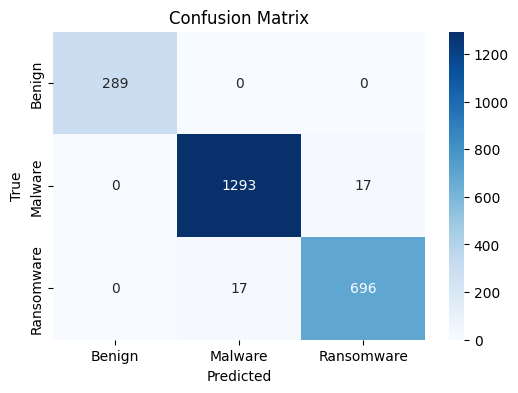

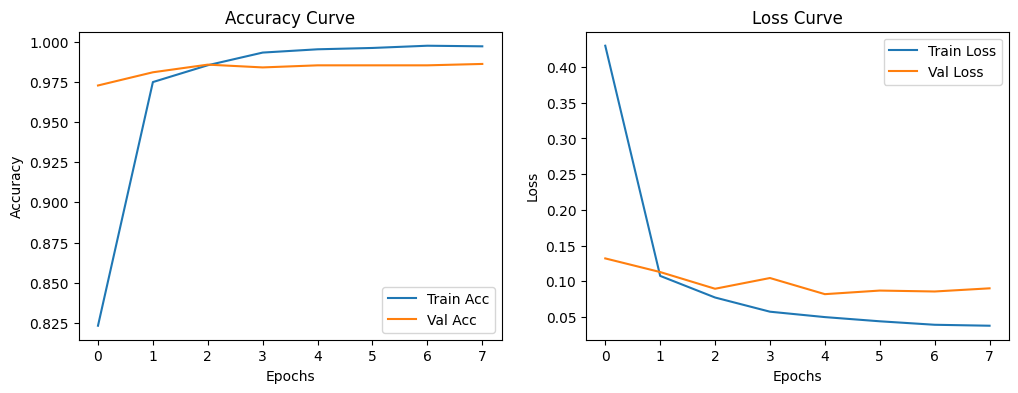

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- 1) Evaluate on validation or test set ----------------
val_loss, val_acc = model.evaluate([Xt_val, Xdy_val], y_val, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# ---------------- 2) Predictions ----------------
y_pred_probs = model.predict([Xt_val, Xdy_val])
y_pred = y_pred_probs.argmax(axis=1)   # convert probabilities → class labels

# ---------------- 3) Classification report ----------------
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Benign", "Malware", "Ransomware"]))

# ---------------- 4) Confusion matrix ----------------
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malware", "Ransomware"],
            yticklabels=["Benign", "Malware", "Ransomware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ---------------- 5) Training curves ----------------
plt.figure(figsize=(12,4))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()


## **Test Set Evaluation Block**

Split Train / Validation / Test

In [ ]:
print("Static features:", Xt.shape if 'Xt' in locals() else "Xt not found")
print("Dynamic features:", Xdy.shape if 'Xdy' in locals() else "Xdy not found")
print("Labels:", y.shape if 'y' in locals() else "y not found")


Static features: Xt not found
Dynamic features: Xdy not found
Labels: y not found


In [ ]:
print("Do we still have:", "Xt_tr" in locals(), "Xdy_tr" in locals(), "y_tr" in locals())


Do we still have: True True True


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Recombine train + val
Xt_full = np.vstack([Xt_tr, Xt_val])
Xdy_full = np.vstack([Xdy_tr, Xdy_val])
y_full = np.concatenate([y_tr, y_val])

print("Full dataset:", Xt_full.shape, Xdy_full.shape, y_full.shape)

# New split: Train 70%, Val 15%, Test 15%
Xt_train, Xt_temp, Xdy_train, Xdy_temp, y_train, y_temp = train_test_split(
    Xt_full, Xdy_full, y_full,
    test_size=0.3, random_state=42, stratify=y_full
)

Xt_val, Xt_test, Xdy_val, Xdy_test, y_val, y_test = train_test_split(
    Xt_temp, Xdy_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", Xt_train.shape, Xdy_train.shape, y_train.shape)
print("Val:", Xt_val.shape, Xdy_val.shape, y_val.shape)
print("Test:", Xt_test.shape, Xdy_test.shape, y_test.shape)


Full dataset: (13101, 2000) (13101, 800) (13101,)
Train: (9170, 2000) (9170, 800) (9170,)
Val: (1965, 2000) (1965, 800) (1965,)
Test: (1966, 2000) (1966, 800) (1966,)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9933 - loss: 0.0582

Test Accuracy: 0.9954
Test Loss: 0.0496
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Test Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       246
     Malware       1.00      0.99      1.00      1114
  Ransomware       0.99      1.00      0.99       606

    accuracy                           1.00      1966
   macro avg       1.00      1.00      1.00      1966
weighted avg       1.00      1.00      1.00      1966



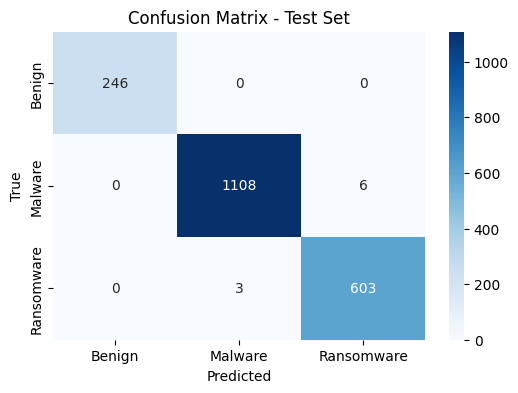

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Evaluate on Test Set ----------------
test_loss, test_acc = model.evaluate([Xt_test, Xdy_test], y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# ---------------- Predictions ----------------
y_test_pred_probs = model.predict([Xt_test, Xdy_test])
y_test_pred = y_test_pred_probs.argmax(axis=1)

# ---------------- Classification Report ----------------
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred,
                            target_names=["Benign", "Malware", "Ransomware"]))

# ---------------- Confusion Matrix ----------------
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malware", "Ransomware"],
            yticklabels=["Benign", "Malware", "Ransomware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


## **Code for Performance + Assessment Metrics**

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       246
     Malware       1.00      0.99      1.00      1114
  Ransomware       0.99      1.00      0.99       606

    accuracy                           1.00      1966
   macro avg       1.00      1.00      1.00      1966
weighted avg       1.00      1.00      1.00      1966



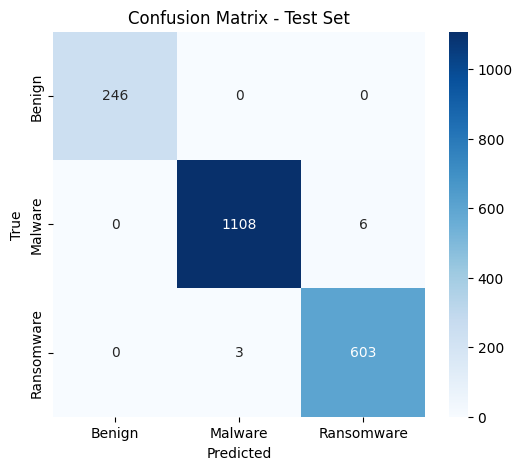

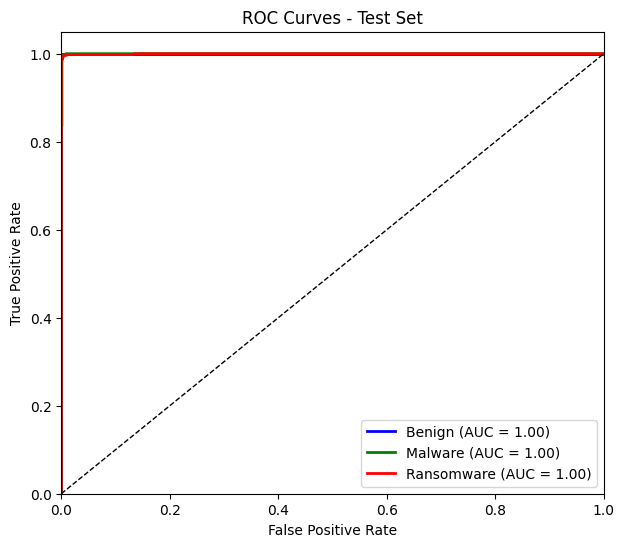

Cohen's Kappa: 0.9919497054503961
Matthews Corrcoef (MCC): 0.9919540029081789
Brier Score (macro): 0.0024638634800053963


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef, brier_score_loss
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

# -------------------- 1. Performance Evaluation Metrics --------------------

# Predict probabilities and labels on test set
y_pred_proba = model.predict([Xt_test, Xdy_test])
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report & confusion matrix
print(classification_report(y_test, y_pred, target_names=["Benign", "Malware", "Ransomware"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malware", "Ransomware"],
            yticklabels=["Benign", "Malware", "Ransomware"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------- ROC Curve + AUC --------------------
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(7,6))
colors = ["blue", "green", "red"]
for i, label in enumerate(["Benign", "Malware", "Ransomware"]):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"{label} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(loc="lower right")
plt.show()

# -------------------- 2. Model Assessment Metrics --------------------
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Matthews Corrcoef (MCC):", matthews_corrcoef(y_test, y_pred))
print("Brier Score (macro):", brier_score_loss(y_test_bin.ravel(), y_pred_proba.ravel()))


## **Final Evaluation Block**

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9933 - loss: 0.0582

Test Accuracy: 0.9954
Test Loss: 0.0496

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       246
     Malware       1.00      0.99      1.00      1114
  Ransomware       0.99      1.00      0.99       606

    accuracy                           1.00      1966
   macro avg       1.00      1.00      1.00      1966
weighted avg       1.00      1.00      1.00      1966



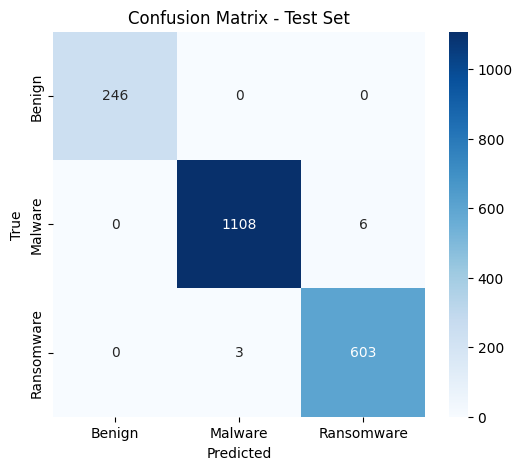

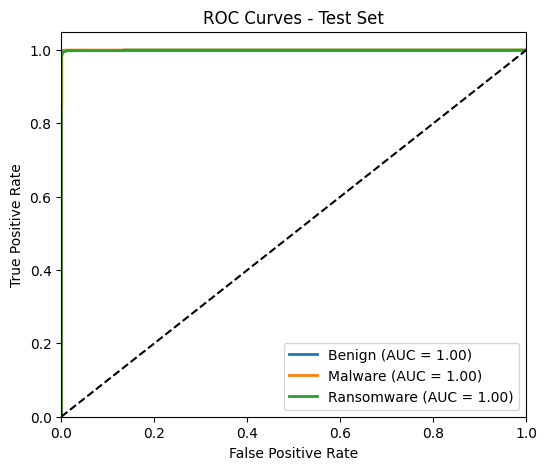

Cohen's Kappa: 0.9919
Matthews Correlation Coefficient (MCC): 0.9920
Brier Score (macro): 0.002464


In [ ]:
# ---------------- Final Evaluation Block ----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    cohen_kappa_score, matthews_corrcoef, brier_score_loss
)
from sklearn.preprocessing import label_binarize

# ----- 1. Evaluate on Test Set -----
test_loss, test_acc = model.evaluate([Xt_test, Xdy_test], y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}\n")

# ----- 2. Predictions -----
y_prob = model.predict([Xt_test, Xdy_test])  # softmax probabilities
y_pred = np.argmax(y_prob, axis=1)

# ----- 3. Classification Report -----
print("Test Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malware", "Ransomware"]))

# ----- 4. Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malware","Ransomware"],
            yticklabels=["Benign","Malware","Ransomware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ----- 5. ROC Curves -----
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0,1,2])  # one-hot for ROC
plt.figure(figsize=(6,5))

for i, label in enumerate(["Benign","Malware","Ransomware"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(loc="lower right")
plt.show()

# ----- 6. Extra Metrics -----
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
brier = brier_score_loss(y_test_bin.ravel(), y_prob.ravel())

print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Brier Score (macro): {brier:.6f}")


## **Stage 1 Trigger Training**

**Option 1 – Random Forest Trigger (classical ML, lightweight & fast)**

In [ ]:
import pandas as pd

# Load your three datasets
benign = pd.read_csv("benign.csv")
malware = pd.read_csv("malware.csv")
ransomware = pd.read_csv("ransomware.csv")

# Add labels
benign["label"] = 0
malware["label"] = 1
ransomware["label"] = 2

# Combine into one dataset
Xt = pd.concat([benign, malware, ransomware], axis=0).reset_index(drop=True)
Xt.to_csv("static_features.csv", index=False)

print("Dataset created:", Xt.shape)
print(Xt.head())


Dataset created: (15414, 32)
  characteristics         compile_time dll_characteristics entry_point error  \
0           0x10e  2007-11-13 03:46:49               0x400      0x5f8e   NaN   
1           0x102  2010-03-18 06:02:35              0x8540      0x2aee   NaN   
2           0x10e  2002-01-04 23:44:14                 0x0      0x4fbe   NaN   
3           0x10e  2004-08-18 12:52:22               0x400      0x2dee   NaN   
4           0x102  2012-12-13 13:57:30              0x8540     0x4199e   NaN   

  exports  file_size              filename  \
0      []    28672.0  Sourceforge_2200.exe   
1      []    11600.0  Sourceforge_4489.exe   
2      []    24576.0  Sourceforge_7609.exe   
3      []    16384.0  Sourceforge_2616.exe   
4      []   289280.0       CNET_257610.exe   

                                            filepath image_base  ...  \
0  /home/christopherxu/Desktop/datasets-old/benig...   0x400000  ...   
1  /home/christopherxu/Desktop/datasets-old/benig...   0x400000  ... 

## **Step 4 – Select Features**

In [ ]:
import pandas as pd

# Load the combined dataset
Xt = pd.read_csv("static_features.csv")

# Separate labels
y = Xt.pop("label")

# Drop non-numeric columns (IDs, hashes, paths, filenames, etc.)
Xt = Xt.drop(columns=[
    "filename", "filepath", "sha1", "sha256", "ssdeep", "exports", "imports", "api_calls"
], errors="ignore")

print("Final feature set:", Xt.shape)
print(Xt.head())


Final feature set: (15414, 23)
  characteristics         compile_time dll_characteristics entry_point error  \
0           0x10e  2007-11-13 03:46:49               0x400      0x5f8e   NaN   
1           0x102  2010-03-18 06:02:35              0x8540      0x2aee   NaN   
2           0x10e  2002-01-04 23:44:14                 0x0      0x4fbe   NaN   
3           0x10e  2004-08-18 12:52:22               0x400      0x2dee   NaN   
4           0x102  2012-12-13 13:57:30              0x8540     0x4199e   NaN   

   file_size image_base is_pe  linker_version machine_type  ... num_resources  \
0    28672.0   0x400000  True             8.0        0x14c  ...           1.0   
1    11600.0   0x400000  True             8.0        0x14c  ...           1.0   
2    24576.0   0x450000  True             6.0        0x14c  ...           1.0   
3    16384.0   0x400000  True             6.0        0x14c  ...           4.0   
4   289280.0   0x400000  True             8.0        0x14c  ...           7.0   

 

**Full Preprocessing Block**

In [ ]:
import pandas as pd

# Load dataset
Xt = pd.read_csv("static_features.csv")

# Separate labels
y = Xt.pop("label")

# Drop clearly non-numeric / text-heavy columns
drop_cols = ["filename", "filepath", "sha1", "sha256", "ssdeep", "exports", "imports", "api_calls"]
Xt = Xt.drop(columns=drop_cols, errors="ignore")

# Convert hex-like strings to integers
for col in Xt.columns:
    if Xt[col].dtype == object:
        Xt[col] = Xt[col].apply(lambda x: int(x, 16) if isinstance(x, str) and str(x).startswith("0x") else x)

# Convert compile_time to numeric (UNIX timestamp)
if "compile_time" in Xt.columns:
    Xt["compile_time"] = pd.to_datetime(Xt["compile_time"], errors="coerce").astype("int64") // 10**9

# Ensure all remaining object columns are removed (drop leftover text)
Xt = Xt.apply(pd.to_numeric, errors="coerce")
Xt = Xt.fillna(0)  # replace NaNs with 0

print("Final feature set:", Xt.shape)
print(Xt.head())


Final feature set: (15414, 23)
   characteristics  compile_time  dll_characteristics  entry_point  error  \
0            270.0    1194925609               1024.0      24462.0    0.0   
1            258.0    1268892155              34112.0      10990.0    0.0   
2            270.0    1010187854                  0.0      20414.0    0.0   
3            270.0    1092833542               1024.0      11758.0    0.0   
4            258.0    1355407050              34112.0     268702.0    0.0   

   file_size  image_base  is_pe  linker_version  machine_type  ...  \
0    28672.0   4194304.0    1.0             8.0         332.0  ...   
1    11600.0   4194304.0    1.0             8.0         332.0  ...   
2    24576.0   4521984.0    1.0             6.0         332.0  ...   
3    16384.0   4194304.0    1.0             6.0         332.0  ...   
4   289280.0   4194304.0    1.0             8.0         332.0  ...   

   num_resources  num_strings  number_of_sections  resources  sections  \
0          

## **Stage 1 Trigger- RandomForest**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Re-label: Benign=0, Malware=1, Ransomware=1 (merge both as "malicious")
y_binary = y.copy()
y_binary = y_binary.replace({1:1, 2:1})

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    Xt, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# Random Forest Binary Trigger
rf_trigger = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Train
rf_trigger.fit(X_train, y_train)

# Evaluate
y_pred = rf_trigger.predict(X_val)

print("Confusion Matrix (Binary):")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report (Binary):")
print(classification_report(y_val, y_pred, digits=4))


Confusion Matrix (Binary):
[[ 385    1]
 [   0 2697]]

Classification Report (Binary):
              precision    recall  f1-score   support

           0     1.0000    0.9974    0.9987       386
           1     0.9996    1.0000    0.9998      2697

    accuracy                         0.9997      3083
   macro avg     0.9998    0.9987    0.9993      3083
weighted avg     0.9997    0.9997    0.9997      3083



## **Connect Stage 1 → Stage 2**

In [ ]:
def malfusion_pipeline(file_features):
    """
    file_features: 1 sample of static features (same format as Xt row)
    """
    # Stage 1 Trigger
    stage1_pred = rf_trigger.predict([file_features])[0]

    if stage1_pred == 0:
        return "Benign"  # Stop here
    else:
        # Stage 2 Fusion (CNN+BiLSTM you already trained)
        stage2_pred = fusion_model.predict(file_features_dynamic)  # your dynamic API call sequence
        return stage2_pred


## **Stage 2 feature preparation**

In [ ]:
import numpy as np

def malfusion_pipeline(static_features, dynamic_sequence):
    """
    static_features: 1 sample of static features (same format as Xt row)
    dynamic_sequence: API call/opcode sequence (preprocessed for fusion model)
    """
    # -------- Stage 1: Trigger (Random Forest) --------
    stage1_pred = rf_trigger.predict([static_features])[0]

    if stage1_pred == 0:
        return "Benign"   # Stop here (fast exit)

    # -------- Stage 2: Fusion (CNN + BiLSTM) --------
    # Add batch dimension for model input
    dynamic_sequence = np.expand_dims(dynamic_sequence, axis=0)

    stage2_pred = fusion_model.predict(dynamic_sequence)
    stage2_class = np.argmax(stage2_pred, axis=1)[0]

    if stage2_class == 1:
        return "Malware"
    elif stage2_class == 2:
        return "Ransomware"
    else:
        return "Benign"   # safety fallback


In [ ]:
import os

# List all files in the current directory
for f in os.listdir():
    print(f)


.config
static_features.csv
benign.csv
ransomware.csv
malware.csv
sample_data


In [ ]:
import json

# Load one uploaded JSON file
with open("report_360.json", "r") as f:
    data = json.load(f)

# Show the top-level keys
print("Top-level keys:", data.keys())

# Peek into behavior if it exists
if "behavior" in data:
    print("\nBehavior keys:", data["behavior"].keys())

    if "apistats" in data["behavior"]:
        # apistats usually maps PIDs → API calls
        print("\nSample from apistats:")
        first_key = list(data["behavior"]["apistats"].keys())[0]
        print("PID:", first_key)
        print("API calls:", list(data["behavior"]["apistats"][first_key].items())[:10])


Top-level keys: dict_keys(['info', 'signatures', 'target', 'network', 'static', 'dropped', 'behavior', 'debug', 'strings', 'metadata'])

Behavior keys: dict_keys(['generic', 'apistats', 'processes', 'processtree', 'summary'])

Sample from apistats:
PID: 508
API calls: [('NtReadFile', 5232), ('CreateThread', 1), ('SetFilePointer', 8490), ('NtQueryDirectoryFile', 97), ('NtDelayExecution', 1), ('SetUnhandledExceptionFilter', 1), ('NtCreateFile', 5661), ('GetFileType', 2863), ('NtAllocateVirtualMemory', 3254), ('NtWriteFile', 110)]


## **Extract API Calls From All JSONs**

In [ ]:
import json
import os
import pandas as pd

def extract_api_calls(json_file):
    """Extract API call sequence from one Cuckoo JSON report."""
    with open(json_file, "r") as f:
        data = json.load(f)

    api_sequence = []
    if "behavior" in data and "apistats" in data["behavior"]:
        apistats = data["behavior"]["apistats"]
        for pid, calls in apistats.items():
            for api_name, count in calls.items():
                api_sequence.extend([api_name] * count)

    return " ".join(api_sequence)

# Path to folder with JSONs
inner_folder = os.path.join("ransomware_92_json", "ransomware 92 json")

rows = []
for fname in os.listdir(inner_folder):
    if fname.endswith(".json"):
        path = os.path.join(inner_folder, fname)
        seq = extract_api_calls(path)
        rows.append({"filename": fname, "api_calls": seq})

# Save to CSV
df_api = pd.DataFrame(rows)
df_api.to_csv("ransomware_api_calls.csv", index=False)

print("Saved ransomware_api_calls.csv with", len(df_api), "samples")
print(df_api.head())


Saved ransomware_api_calls.csv with 92 samples
          filename                                          api_calls
0  report_423.json  LdrUnloadDll RegCloseKey RegCloseKey RegCloseK...
1  report_438.json  NtReadFile NtReadFile NtReadFile NtReadFile Nt...
2  report_376.json  LdrUnloadDll LdrUnloadDll LdrUnloadDll LdrUnlo...
3  report_375.json  NtReadFile NtReadFile NtReadFile NtReadFile Nt...
4  report_468.json  LdrUnloadDll RegCloseKey RegCloseKey RegCloseK...


**Tokenize & Pad API Calls**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the new ransomware API CSV
import pandas as pd
df_api = pd.read_csv("ransomware_api_calls.csv")

# Tokenizer for API calls
tokenizer = Tokenizer(filters='', lower=False, split=' ')
tokenizer.fit_on_texts(df_api["api_calls"])

# Convert to integer sequences
sequences = tokenizer.texts_to_sequences(df_api["api_calls"])

# Pad sequences to same length
max_len = 400   # adjust later if needed
Xt_dynamic = pad_sequences(sequences, maxlen=max_len, padding="post")

print("Xt_dynamic shape:", Xt_dynamic.shape)
print("Example sequence:", Xt_dynamic[0][:50])  # first 50 tokens of first sample


Xt_dynamic shape: (92, 400)
Example sequence: [47 24 24 24 32 22 57 38 38 38 46  3  3  5  5  5  5  5  5  5  5  5  5 42
 42 42 36 36 36 67  9 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [ ]:
# Load static features
df_static = pd.read_csv("static_features.csv")

# Load ransomware api_calls
df_api = pd.read_csv("ransomware_api_calls.csv")

# Merge them on filename (keep only rows that exist in both)
df_merged = df_static.merge(df_api, on="filename", how="inner")

print("Merged dataset:", df_merged.shape)
print(df_merged.head())


Merged dataset: (0, 33)
Empty DataFrame
Columns: [characteristics, compile_time, dll_characteristics, entry_point, error, exports, file_size, filename, filepath, image_base, imports, is_pe, linker_version, machine_type, md5, num_exports, num_imports, num_resources, num_strings, number_of_sections, resources, sections, sha1, sha256, size_of_image, ssdeep, strings, subsystem, label, instructions, api_calls_x, json, api_calls_y]
Index: []

[0 rows x 33 columns]


In [ ]:
import pandas as pd

df_static = pd.read_csv("static_features.csv")
print(df_static.columns[:20])   # show first 20 columns
print(df_static[["filename", "md5", "sha1", "sha256"]].head())


Index(['characteristics', 'compile_time', 'dll_characteristics', 'entry_point',
       'error', 'exports', 'file_size', 'filename', 'filepath', 'image_base',
       'imports', 'is_pe', 'linker_version', 'machine_type', 'md5',
       'num_exports', 'num_imports', 'num_resources', 'num_strings',
       'number_of_sections'],
      dtype='object')
               filename                               md5  \
0  Sourceforge_2200.exe  e1bddf96c9931239f208e7ee8359cf4e   
1  Sourceforge_4489.exe  02be6d33b1edbc61c79882d3f556bd8a   
2  Sourceforge_7609.exe  1ab41a0b068c2dccca6a9e81d2e3733d   
3  Sourceforge_2616.exe  e3b73ba72989e9c5d8ea7a89649546f9   
4       CNET_257610.exe  3c50a665ca289ee13eb3647af87ce8e6   

                                       sha1  \
0  a8399c3cf3d3afab478c821cddc42e44d49ab75e   
1  8d0afa78893ae5f04e505db0d76d0d50cf34e7da   
2  4b699ba3a3a22866bef1532a4c97b6ea69609547   
3  8b72c3e12edf4c99663517f285b468d11eca0753   
4  a9b9a74db53948da4e6b576fb4556001f4d3395f   

   

**Inspect One JSON for Hashes**

In [ ]:
import json

json_path = os.path.join("ransomware_92_json", "ransomware 92 json", "report_423.json")

with open(json_path, "r") as f:
    data = json.load(f)

# Print available top-level keys
print("Top-level keys:", data.keys())

# Look inside 'target' and 'file' info (Cuckoo usually stores hashes here)
if "target" in data:
    print("\nTarget keys:", data["target"].keys())
    if "file" in data["target"]:
        print("\nFile keys:", data["target"]["file"].keys())
        print("File info:", data["target"]["file"])


Top-level keys: dict_keys(['info', 'signatures', 'target', 'network', 'static', 'behavior', 'debug', 'strings', 'metadata'])

Target keys: dict_keys(['category', 'file'])

File keys: dict_keys(['yara', 'sha1', 'name', 'type', 'sha256', 'urls', 'crc32', 'path', 'ssdeep', 'size', 'sha512', 'md5'])
File info: {'yara': [], 'sha1': '1cb33ca72dfc41963c1e66e6dea77af66385cf79', 'name': '1acf86d8d8f885d9e0aa80cff7fedba3809069229b675fca0fcb77bc755161ed', 'type': 'PE32 executable (GUI) Intel 80386, for MS Windows, 5 sections', 'sha256': '1acf86d8d8f885d9e0aa80cff7fedba3809069229b675fca0fcb77bc755161ed', 'urls': [], 'crc32': 'F28D8065', 'path': '/media/reu/1b8e3f03-5641-4a07-ab18-eae8e8bd28f0/.cuckoo/storage/binaries/1acf86d8d8f885d9e0aa80cff7fedba3809069229b675fca0fcb77bc755161ed', 'ssdeep': None, 'size': 745472, 'sha512': 'a3308e58f7b515b6106b4fc15e0ae7d5a1ebd70e8d1e47b93d0530a9decedf0724cb98f8484f8d448b7679bb3a5c42dfcc9faeffd7b30c342fb7373e51d51c0a', 'md5': '31dfac1de3d95db296f99d2bf0e31294'}


## **Extract API Calls + Hash**

In [ ]:
import json
import os
import pandas as pd

def extract_api_calls_and_hash(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)

    api_sequence = []
    if "behavior" in data and "apistats" in data["behavior"]:
        apistats = data["behavior"]["apistats"]
        for pid, calls in apistats.items():
            for api_name, count in calls.items():
                api_sequence.extend([api_name] * count)

    # Get hashes
    md5 = sha1 = sha256 = None
    if "target" in data and "file" in data["target"]:
        fileinfo = data["target"]["file"]
        md5 = fileinfo.get("md5")
        sha1 = fileinfo.get("sha1")
        sha256 = fileinfo.get("sha256")

    return {
        "filename": os.path.basename(json_file),
        "md5": md5,
        "sha1": sha1,
        "sha256": sha256,
        "api_calls": " ".join(api_sequence)
    }

# Process all JSONs in the ransomware folder
inner_folder = os.path.join("ransomware_92_json", "ransomware 92 json")
rows = []

for fname in os.listdir(inner_folder):
    if fname.endswith(".json"):
        path = os.path.join(inner_folder, fname)
        rows.append(extract_api_calls_and_hash(path))

df_api = pd.DataFrame(rows)
df_api.to_csv("ransomware_api_calls_with_hash.csv", index=False)

print("Saved ransomware_api_calls_with_hash.csv with", len(df_api), "samples")
print(df_api.head())


Saved ransomware_api_calls_with_hash.csv with 92 samples
          filename                               md5  \
0  report_423.json  31dfac1de3d95db296f99d2bf0e31294   
1  report_438.json  4bb3325d29ffa46c408c8d5213159199   
2  report_376.json  0dcd0afc1c7bd55993a3c54725861384   
3  report_375.json  cef906f87891aff1973adbdc0c5a80bc   
4  report_468.json  3c57c6fb9e81f491632590a2b96b3774   

                                       sha1  \
0  1cb33ca72dfc41963c1e66e6dea77af66385cf79   
1  f0ddf076a3e6edb3152fa70daccfe8d98346d1db   
2  a17d6796674978b8a002292f6be3d89709818b0c   
3  dc9adf41a0edd43d7823f3cdbad8287d140a5994   
4  af358028d0ba49544aebb9b359b2468b5d0a2154   

                                              sha256  \
0  1acf86d8d8f885d9e0aa80cff7fedba3809069229b675f...   
1  1b5d67c86721b35c1f95e728e7d8562bc68c6dc542cf67...   
2  190805b6c316496fa034cd7980eff4fae756538fb1e32a...   
3  18ff4ccbbfd687bcf39396e9c3f7d56c4ee7e9efda686c...   
4  1c5d874c094db130895f7e29bf35563b49c7163a

**Merge Static + Dynamic on sha1**

In [ ]:
import pandas as pd

# Load static + dynamic
df_static = pd.read_csv("static_features.csv")
df_api = pd.read_csv("ransomware_api_calls_with_hash.csv")

# Merge on sha1
df_merged = df_static.merge(df_api, on="sha1", how="inner")

print("Merged dataset:", df_merged.shape)
print(df_merged[["filename_x", "filename_y", "label", "sha1"]].head())


Merged dataset: (0, 36)
Empty DataFrame
Columns: [filename_x, filename_y, label, sha1]
Index: []


**save datasets permanently in Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

path = "/content/drive/MyDrive/CyberFusionData/"

benign = pd.read_csv(path + "benign.csv")
malware = pd.read_csv(path + "malware.csv")
ransomware = pd.read_csv(path + "ransomware.csv")


## **Confusion Matrix – Static Random Forest Trigger**

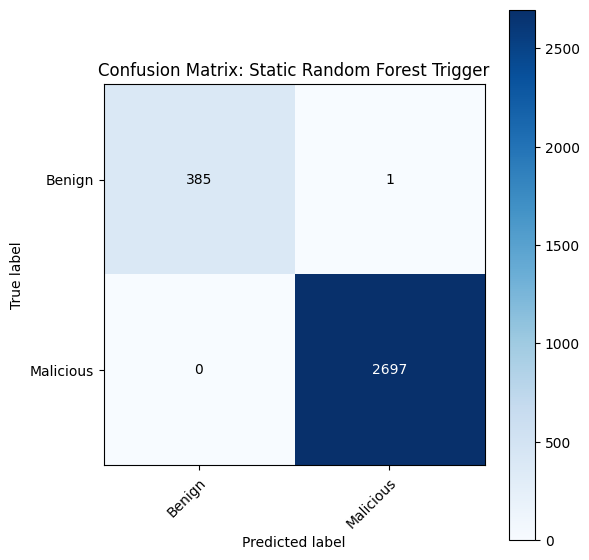

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Manually input the confusion matrix results
cm = np.array([[385, 1],
               [0, 2697]])

classes = ["Benign", "Malicious"]

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

# Add colorbar
plt.colorbar(im, ax=ax)

# Labels
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix: Static Random Forest Trigger"
)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Write numbers inside the boxes
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
